In [136]:
import os
import glob
#import nibabel as nib
import numpy as np
import cv2
# import math
import torch
import scipy

import matplotlib.pyplot as plt
import plotly.express as px
import csv
import re
import pandas as pd
from matplotlib.colors import ListedColormap

import sys
sys.path.append('../')

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
print(f"[Using {device} device]")

[Using cpu device]


### Utility functions

In [138]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask > 0))[:, 1]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last

def plot_tumour(mask: torch.Tensor):
    """Plot individual slices of the tumour in one figure."""
    
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(mask[0, i, :, :], cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()

def plot_cuts(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
        tmp_cut = torch.clone(cut)
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

def plot_cuts_with_seq(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = 4
    cols = 3
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        
        # if len(cut.shape) == 3:
        #     cut = cut.squeeze(0)
        
        tmp_cut = torch.clone(cut[0])
        if plot_click:
            tmp_cut[cut[0].shape[0]//2, cut[0].shape[0]//2] = 2
        axs[j].imshow(cut[1], cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f't1 cut {i}', fontsize=9)
        axs[j+1].imshow(cut[2], cmap='gray')
        axs[j+1].axis('off')
        axs[j+1].set_title(f't2 cut {i}', fontsize=9)
        axs[j+2].imshow(tmp_cut, cmap=cmap)
        axs[j+2].axis('off')
        axs[j+2].set_title(f'seg cut {i}', fontsize=9)
        j += 3

    plt.show()   

def plot_cuts_with_true(cuts: list[torch.Tensor], true_cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0

    colormap = {
        'bg': 'black',
        'pred': 'purple',
        'true': 'red',
        'overlap': 'orange',
        'click': 'yellow'
    }
    cmap = ListedColormap([colormap['bg'], colormap['pred'], colormap['true'], colormap['overlap'], colormap['click']])
    
    for i, (cut, true_cut) in enumerate(zip(cuts, true_cuts)):
        if j >= len(axs): 
            break
        
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
            true_cut = true_cut.squeeze(0)
        
        tmp_cut = torch.clone(cut)
        tmp_true_cut = torch.clone(true_cut)
        tmp_true_cut[tmp_true_cut == 1] = 2
        
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        
        axs[j].imshow(tmp_cut + tmp_true_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

In [139]:
def get_unused_data(model_path, data_path):
    # Load used training files from csv
    d = os.path.join(model_path, "training_files.csv")
    pd.read_csv(os.path.join(model_path, "training_files.csv"))

    used_files = []
    with open(d) as file:
        training_files = csv.reader(file)
        used_files = [f for f in training_files]
    used_files.pop(0)

    # modify the loaded paths to match the local fs
    # pattern = r"VS-\d+-\d+/vs_\w+/\w+\w+\.nii\.gz"
    used_t1 = []
    used_t2 = []
    used_seg = []

    for paths in used_files:
        used_t1.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t1_\w+\.nii\.gz", paths[0]).group()))
        used_t2.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t2_\w+\.nii\.gz", paths[1]).group()))
        used_seg.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_seg_\w+\.nii\.gz", paths[2]).group()))

    print(len(used_t1), len(used_t2), len(used_seg))
    print(used_t1[:3])
    print(used_t2[:3])
    print(used_seg[:3])

    # os.listdir(data_path)
    t1_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t1_*")))
    t2_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t2_*")))
    seg_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_seg_*")))
    print(t1_list[:2])

    unused_t1 = sorted(list(set(t1_list) - set(used_t1)))
    unused_t2 = sorted(list(set(t2_list) - set(used_t2)))
    unused_seg = sorted(list(set(seg_list) - set(used_seg)))

    print(len(unused_t1), len(unused_t2), len(unused_seg))

    return unused_t1, unused_t2 , unused_seg

### Pipeline

In [140]:
cutsize = 48

**Setting up data paths**

In [141]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))
print(t1_list)

['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_13/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_14/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_15/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_16/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_17/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_18/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_19/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_2/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_20/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_21/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_22/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_23/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_24/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_25/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_26

#### Segmentation

In [142]:
from src.model.segmentation import Unet
from src.data.data_generator import MRIDataset
from src.losses.dice import dice_coefficient

In [143]:
model_path = "../models/pretraining_focaltversky_32imgs"
# model_path = "../models/pretraining_4blocks_64imgs"
os.listdir(model_path)

['val_history.json',
 'training_files.csv',
 'validation_files.csv',
 'train_history.json',
 'best.pt',
 'checkpoint.pt',
 'architecture.txt']

In [144]:
model = Unet(in_channels=2, out_channels=1, blocks=3).to(device)
# model = Unet(in_channels=2, out_channels=1, blocks=4).to("cpu")

checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location=device)
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

**Getting unused data**

In [145]:
unused_t1, unused_t2 , unused_seg = get_unused_data(model_path, data_path="../data/all/")

32 32 32
['../data/all/VS-62-91/vs_gk_86/vs_gk_t1_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t1_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t1_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_t2_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t2_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t2_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_seg_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_seg_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_seg_refT2.nii.gz']
['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz']
210 210 210


In [146]:
new_data = MRIDataset(
    unused_t1, unused_t2 , unused_seg, (48, 256, 256), clicks=None
)

**Rough segmentation**

In [147]:
# with torch.no_grad():
#     for i, (x, y) in enumerate(new_data):
#         y_pred = model(x.unsqueeze(0))
#         y_threshed = (y_pred > 0.6).type(torch.float32)
#         print(i, dice_coefficient(y_threshed, y))

In [148]:
x, y = new_data[19]
with torch.no_grad():
    y_pred = model(x.unsqueeze(0).to(device))

In [149]:
y_threshed = (y_pred > 0.6).type(torch.float32).cpu()
print(dice_coefficient(y_threshed, y))
# y_threshed = y_threshed.squeeze(0)

tensor(0.8608)


Tumour indices:  26 40


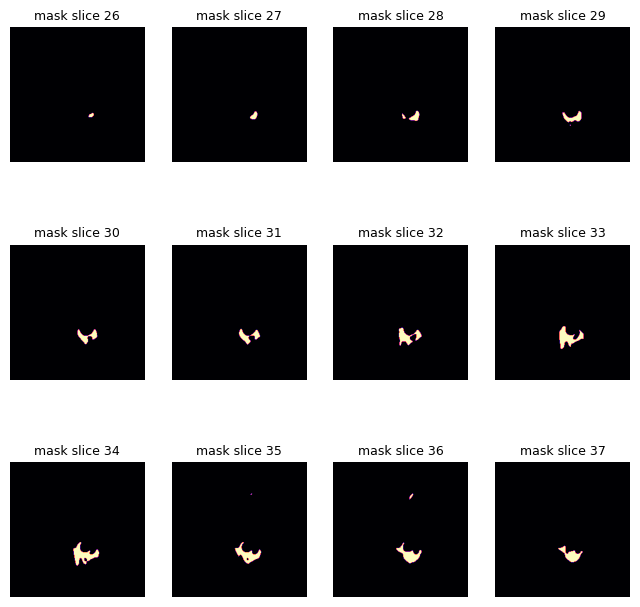

In [150]:
plot_tumour(y_threshed[0])

Tumour indices:  24 42


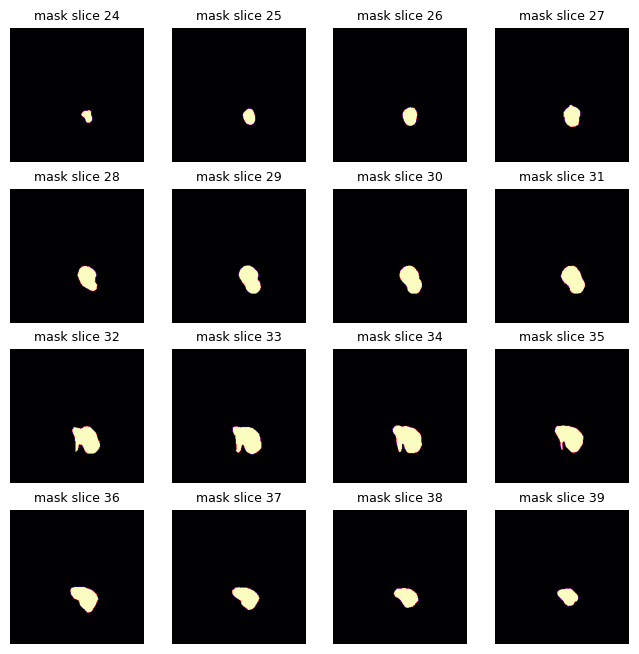

In [151]:
plot_tumour(y)

#### Generating clicks

In [152]:
from src.data.utils import _select_points

def get_border(mask: torch.Tensor):
    mask = mask.numpy()
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(3, 3))
    eroded_seg = cv2.erode(mask, kernel=erosion_kernel)
    border = mask - eroded_seg
    
    return border

def get_potential_coords(y_coords: list, diff_coords: list):
    # get coords (potential clicks), 
    # that are also in the original seg
    potential_clicks = []
    for coord in y_coords:
        if coord in diff_coords:
            potential_clicks.append(coord)
    
    return potential_clicks

def get_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    border = get_border(mask)
    
    if len(mask[mask == 1]) > len(pred[pred == 1]):
        dst = scipy.ndimage.distance_transform_edt(1 - pred)
    else:
        dst = scipy.ndimage.distance_transform_edt(pred)
        # dst = 1 - dst
        # dst[dst == 1] = 0
        # dst[dst != 0] -= np.min(dst)
    weighted_border = dst * border 
    
    if weighted_border.max() == 0.0:
        return torch.zeros_like(mask)

    # maybe find pixels in certain threshold
    indicies = np.where(weighted_border == weighted_border.max())
    clicks_coords = list(zip(*indicies))
    
    # select_clicks
    selected_points = _select_points(np.array(clicks_coords), clicks_num, clicks_dst)
    clicks = np.zeros_like(mask)
    for c in selected_points:
        clicks[c[0], c[1]] = 1

    return torch.as_tensor(clicks)

def simulate_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    clicks = torch.zeros_like(mask)
    start, end = get_glioma_indices(pred)
    for slice_idx in range(start, end+1):
        clicks[0,slice_idx] = get_clicks(mask[0,slice_idx], pred[0,slice_idx], clicks_num, clicks_dst, seed)
    return clicks

In [153]:
new_clicks = simulate_clicks(y, y_threshed[0], clicks_num=5, clicks_dst=10)
new_clicks.shape

torch.Size([1, 48, 256, 256])

#### Generating cuts

In [154]:
def cut_volume(seg: torch.Tensor, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(seg[1])

    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # Cut the volume based on the specified cut size
        cut = torch.clone(seg[0][coords[0]])
        cut = cut[
            coords[1] - cut_size : coords[1] + cut_size,
            coords[2] - cut_size : coords[2] + cut_size,
        ].unsqueeze(0)

        # print(cut.shape, coords)
        
        cuts.append(cut)

    return cuts

def generate_cuts(seg, seq, clicks, cut_size):
    seg_cuts = cut_volume(torch.stack((seg, clicks)), cut_size=cut_size)
    t1_cuts = cut_volume(torch.stack((seq[0], clicks)), cut_size=cut_size)
    t2_cuts = cut_volume(torch.stack((seq[1], clicks)), cut_size=cut_size)

    return seg_cuts, t1_cuts, t2_cuts

In [155]:
seg_cuts, t1_cuts, t2_cuts = generate_cuts(y_threshed[0,0], x, new_clicks[0], cut_size=cutsize)

cuts = []
for seg_cut, t1_cut, t2_cut in zip(seg_cuts, t1_cuts, t2_cuts):
    cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))

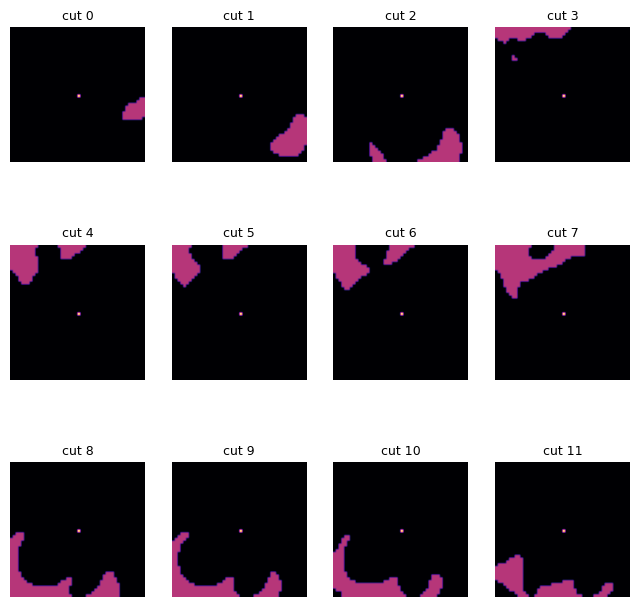

In [156]:
plot_cuts(seg_cuts)

comparison between cuts from the ground truth segmentation and cuts from the prediction

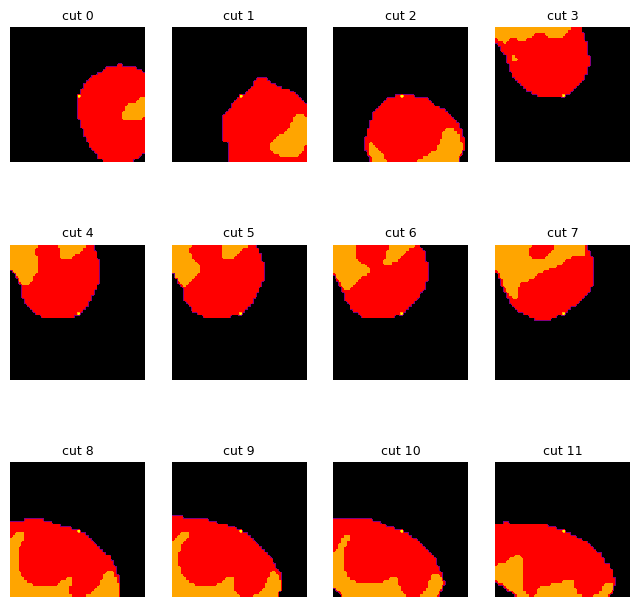

In [157]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(seg_cuts, true_cuts)

In [158]:
dsc = []
for x, y_true in zip(seg_cuts, true_cuts):
    dsc.append(dice_coefficient(x, y_true))
print(np.mean(dsc))

0.57270044


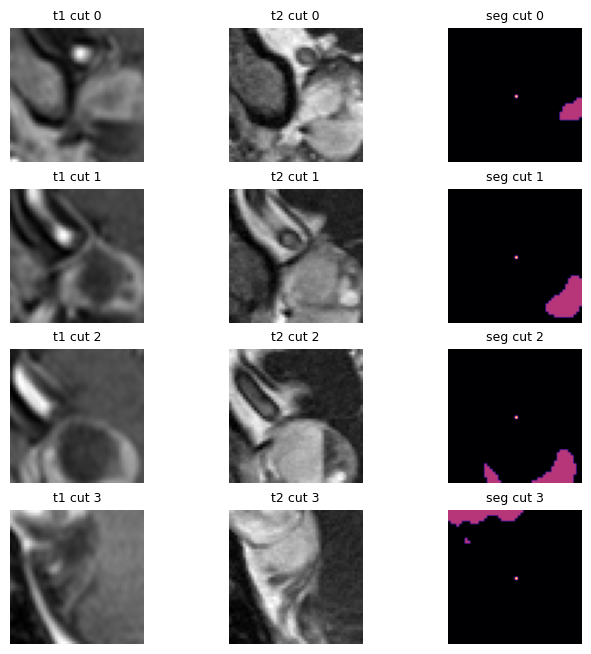

In [159]:
plot_cuts_with_seq(cuts)

#### Correction model

In [160]:
from src.model.correction import CorrectionUnet, OGCorrectionUnet, MultiModalCorrectionUnet, MultiModal3BlockCorrectionUnet

In [161]:
# checkpoint = torch.load(os.path.join("../models/invertedcorrection_allimgs_morechannels_noattention_dropout_3blocks_seq", "best.pt"), map_location=device)
checkpoint = torch.load(os.path.join("../models/multimodal_finetunning_correction", "best.pt"), map_location=device)
# checkpoint = torch.load(os.path.join("../models/multimodal_invertedcorrection_allimgs_morechannels_dropout_3blocks_seq", "best.pt"), map_location=device)


# checkpoint = torch.load(os.path.join("../models/multimodal_diceloss_allimgs_morechannels_4blocks_seq", "best.pt"), map_location="mps")
# checkpoint = torch.load(os.path.join("../models/multimodal_dice_allimgs_morechannels_dropout_4blocks_seq", "best.pt"), map_location="mps")

# checkpoint = torch.load(os.path.join("../models/volumetric_multimodal_correction_4dept_allimgs_morechannels_dropout_3blocks_seq", "best.pt"), map_location=device)

# correction_model = OGCorrectionUnet(in_channels=3, out_channels=1, blocks=3).to("mps")
# correction_model = CorrectionUnet(in_channels=3, out_channels=1, blocks=3, use_attention=False, block_channels=[32, 64, 128, 256]).to(device)
# correction_model = MultiModalCorrectionUnet(in_channels=[1, 2], out_channels=1, blocks=3, encoders=2, block_channels=[32, 64, 128, 256], use_dropout=True).to("mps")
correction_model = MultiModal3BlockCorrectionUnet(in_channels=[1, 2], out_channels=1, blocks=3, encoders=2, block_channels=[32, 64, 128, 256], use_dropout=True, volumetric=False).to(device)
correction_model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [162]:
cutsize = 48

**Correcting cuts**

In [163]:
pred_cuts = []
with torch.no_grad():
    for cut in cuts:
        cut = cut.unsqueeze(0).to(device)
        y_pred = correction_model(cut)
        pred_cuts.append(y_pred.cpu())

In [164]:
for i, cut in enumerate(pred_cuts):
    pred_cuts[i] = cut.squeeze(0).cpu()

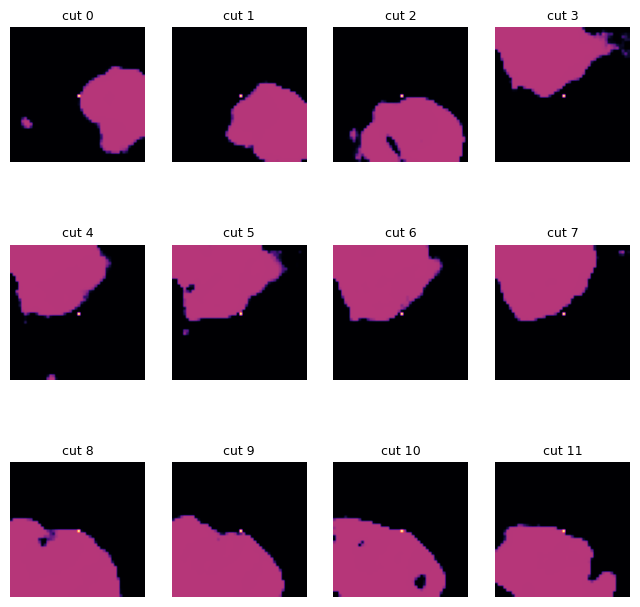

In [165]:
plot_cuts(pred_cuts)

comparison between the ground truth cuts and corrected cuts

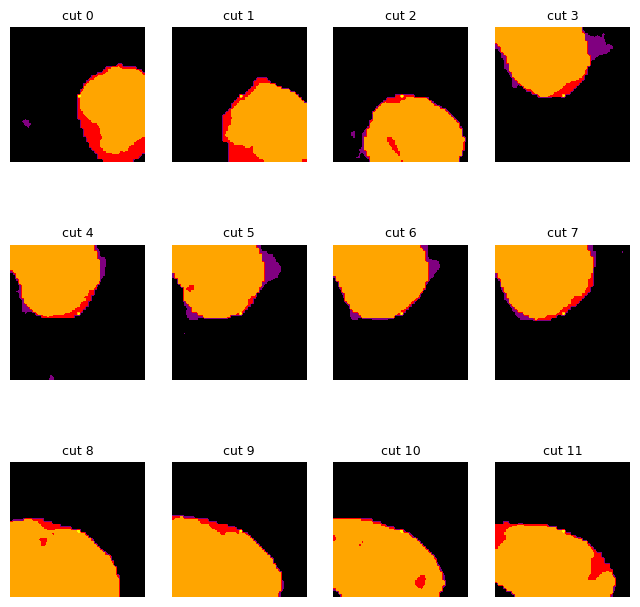

In [166]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(pred_cuts, true_cuts)

##### Multiple iterations with the same cuts

In [167]:
new_cuts = []
for pred_cut, cut in zip(pred_cuts, cuts):
    if len(pred_cut.shape) == 2:
        pred_cut = pred_cut.unsqueeze(0)
    new_cuts.append(torch.cat((pred_cut, cut[1:])))

In [168]:
pred_cuts = []
with torch.no_grad():
    for cut in new_cuts:
        cut = cut.unsqueeze(0).to(device)
        y_pred = correction_model(cut)
        pred_cuts.append(y_pred)

In [169]:
for i, cut in enumerate(pred_cuts):
    cut = (cut > 0.6).type(torch.float32)
    pred_cuts[i] = cut.squeeze(0).cpu()

In [170]:
dsc = []
for x, y_true in zip(pred_cuts, true_cuts):
    dsc.append(dice_coefficient(x, y_true))
print(np.mean(dsc))

0.9453933


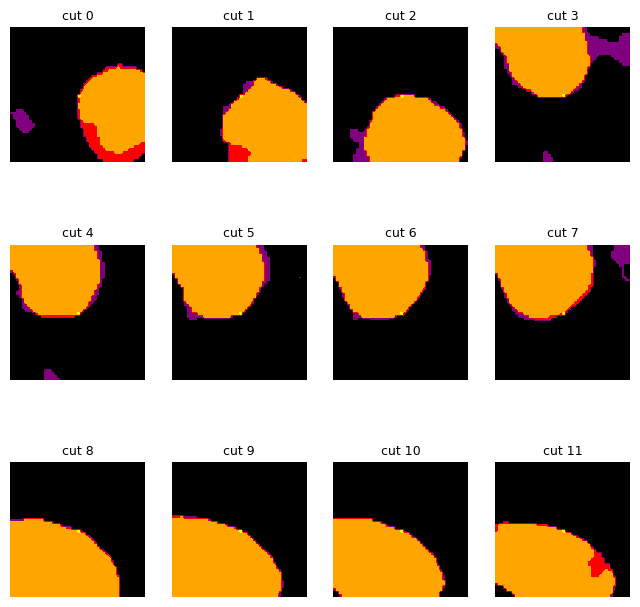

In [171]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(pred_cuts, [cut.squeeze(0) for cut in true_cuts])

#### Fine-tunning

In [123]:
def get_fine_tunning_data(segmentation_model, y_threshed, data, cutsize):
    x, y = data[19]
    # with torch.no_grad():
    #     y_pred = segmentation_model(x.unsqueeze(0))
    # y_threshed = (y_pred > 0.6).type(torch.float32)
    # print(dice_coefficient(y_threshed, y))
    
    new_clicks = simulate_clicks(y, y_threshed[0], clicks_num=5, clicks_dst=10)
    seg_cuts, t1_cuts, t2_cuts = generate_cuts(y_threshed[0,0], x, new_clicks[0], cut_size=cutsize)

    cuts = []
    for seg_cut, t1_cut, t2_cut in zip(seg_cuts, t1_cuts, t2_cuts):
        cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))
    
    true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)

    return true_cuts, cuts

In [124]:
true_cuts, new_training_cuts = get_fine_tunning_data(model, y_threshed, new_data, 48)

In [125]:
new_training_cuts[0].shape

torch.Size([3, 48, 48])

In [126]:
true_cuts[0].shape

torch.Size([1, 48, 48])

In [127]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

In [128]:
from src.losses.dice import dice_coefficient, DiceLoss
loss_fn = DiceLoss()

In [129]:
model.train()
avg_loss, avg_dice = 0, 0
for i, (x, y) in enumerate(zip(new_training_cuts, true_cuts)):
    x, y = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
    optimizer.zero_grad()

    print(x.shape)

    # Get prediction
    y_pred = correction_model(x)

    # Compute loss and dice coefficient

    loss = loss_fn(y_pred, y)
    dice = dice_coefficient(y_pred, y)
    # print(loss.shape)
    # print(dice.shape)

    avg_loss += loss.item()
    avg_dice += dice.item()

    # Update parameters
    loss.backward()
    optimizer.step()

    print(f"training step: {i+1}/{len(new_training_cuts)}, loss: {loss.item():>5f}, dice: {dice.item():>5f}", end="\r")

avg_loss /= len(new_training_cuts)
avg_dice /= len(new_training_cuts)
print()

torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48]) 0.081565, dice: 0.918435
torch.Size([1, 3, 48, 48]) 0.048256, dice: 0.951744
torch.Size([1, 3, 48, 48]) 0.065551, dice: 0.934449
torch.Size([1, 3, 48, 48]) 0.089978, dice: 0.910022
torch.Size([1, 3, 48, 48]) 0.059050, dice: 0.940950
torch.Size([1, 3, 48, 48]) 0.055815, dice: 0.944185
torch.Size([1, 3, 48, 48]) 0.039366, dice: 0.960634
torch.Size([1, 3, 48, 48]) 0.064687, dice: 0.935313
torch.Size([1, 3, 48, 48]) 0.016535, dice: 0.983465
torch.Size([1, 3, 48, 48]): 0.020487, dice: 0.979513
torch.Size([1, 3, 48, 48]): 0.026609, dice: 0.973391
torch.Size([1, 3, 48, 48]): 0.048675, dice: 0.951325
torch.Size([1, 3, 48, 48]): 0.060014, dice: 0.939986
torch.Size([1, 3, 48, 48]): 0.062746, dice: 0.937254
training step: 15/15, loss: 0.155139, dice: 0.844861


In [130]:
pred_cuts = []
for cut in cuts:
    cut = cut.unsqueeze(0).to(device)
    y_pred = correction_model(cut)
    pred_cuts.append(y_pred)

#### Reconstruction of the volume

In [177]:
def reconstruct_volume(seg: torch.Tensor, clicks, cuts, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(clicks[0])

    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]
        
        cut = cuts[click_idx]
        # print(cut.shape, coords)
        seg[0, coords[0], coords[1] - cut_size : coords[1] + cut_size, coords[2] - cut_size : coords[2] + cut_size] = cut 

    return seg

In [178]:
reconstructed_y = reconstruct_volume(y_threshed[0].clone(), new_clicks, pred_cuts, cut_size=cutsize)

In [179]:
dice_coefficient(y_threshed[0], y)

tensor(0.7342)

In [180]:
dice_coefficient(reconstructed_y, y)

tensor(0.8602)

Tumour indices:  26 40


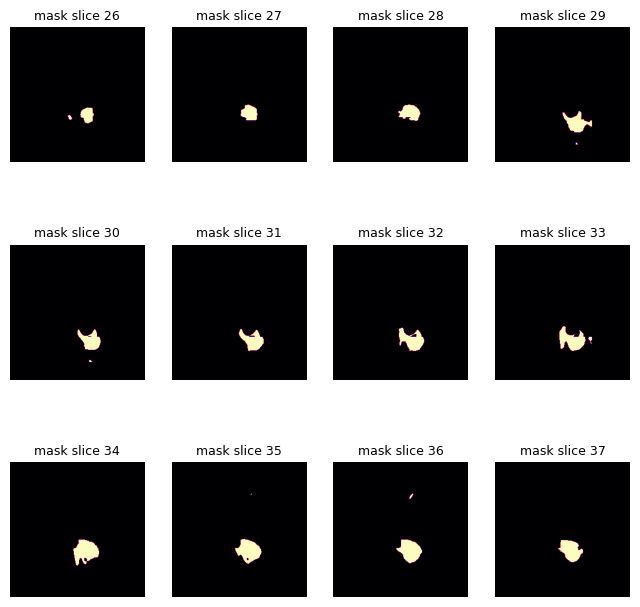

In [184]:
plot_tumour(reconstructed_y.detach())

#### Another iteration

**generating new clicks and cuts**

In [182]:
new_clicks = simulate_clicks(y, reconstructed_y, clicks_num=5, clicks_dst=10)

In [183]:
seg_cuts, t1_cuts, t2_cuts = generate_cuts(reconstructed_y[0], x, new_clicks[0], cut_size=cutsize)

cuts = []
for seg_cut, t1_cut, t2_cut in zip(seg_cuts, t1_cuts, t2_cuts):
    cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))

print(len(seg_cuts), len(t1_cuts), len(t2_cuts))
print(len(cuts))

RuntimeError: stack expects each tensor to be equal size, but got [48, 48] at entry 0 and [48, 256, 256] at entry 1

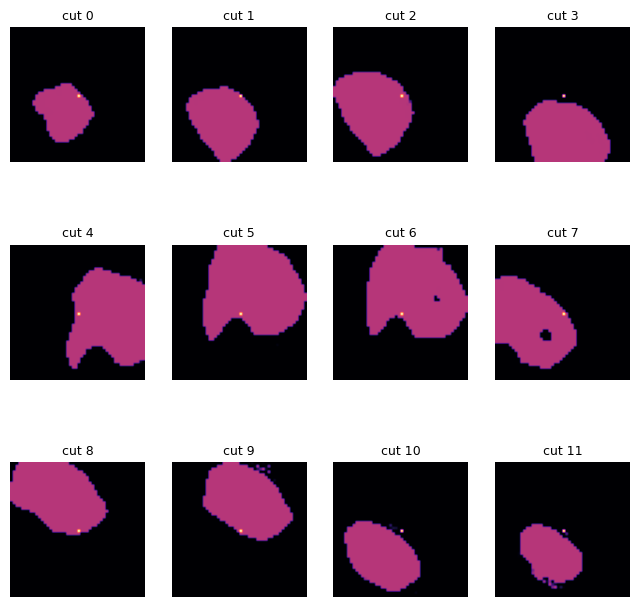

In [ ]:
plot_cuts(seg_cuts)

**correcting cuts**

In [ ]:
pred_cuts = []
with torch.no_grad():
    for cut in cuts:
        cut = cut.unsqueeze(0).to('mps')
        y_pred = correction_model(cut)
        pred_cuts.append(y_pred)

In [ ]:
for i, cut in enumerate(pred_cuts):
    pred_cuts[i] = cut.squeeze(0).cpu()

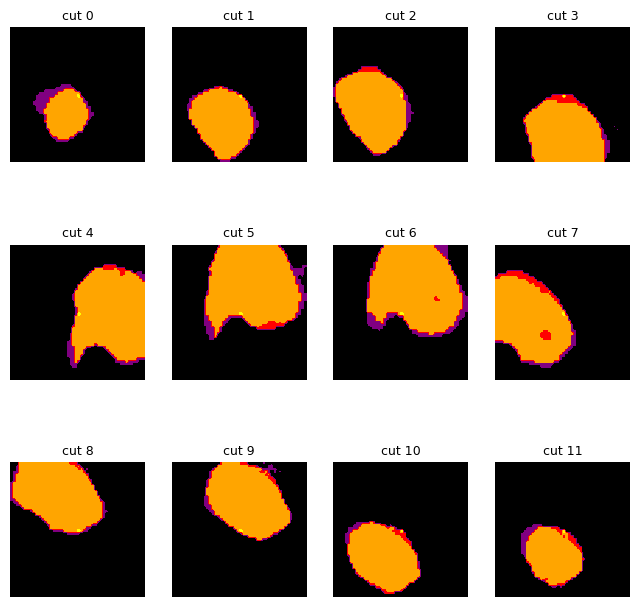

In [ ]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(pred_cuts, true_cuts)

In [ ]:
reconstructed_y = reconstruct_volume(reconstructed_y, new_clicks, pred_cuts, cut_size=cutsize)
dice_coefficient(reconstructed_y, y)

tensor(0.7850)

Tumour indices:  16 29


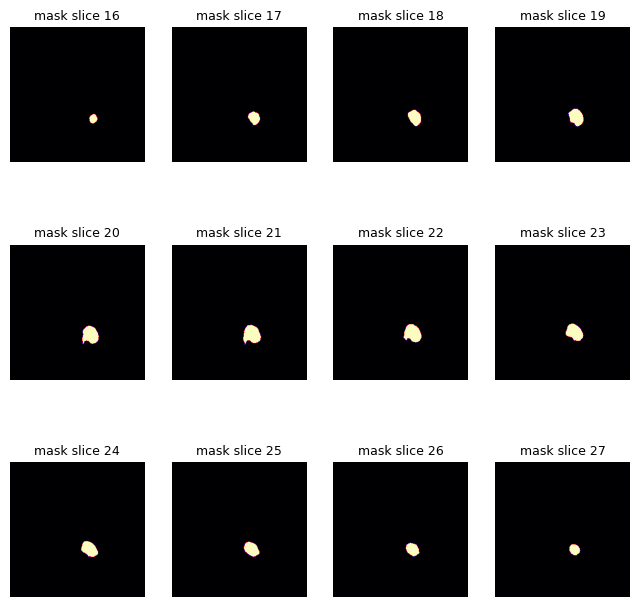

In [ ]:
plot_tumour(y)

Tumour indices:  14 38


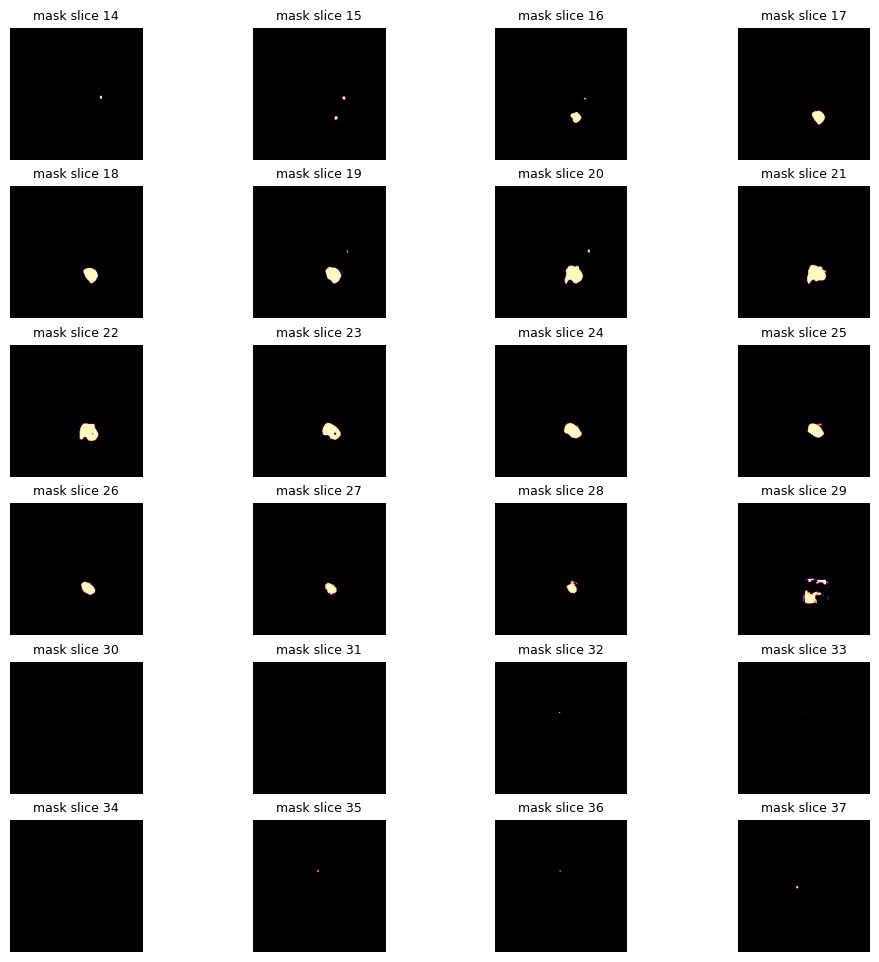

In [ ]:
plot_tumour(reconstructed_y)